In [4]:
#pip install Keras
#pip install tenserflow
#!pip install eli5
#!pip install skater
!pip install altair
!pip install altair_viewer
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from dmba import classificationSummary
#from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import eli5
from eli5.sklearn import PermutationImportance
from altair import Chart
import altair as alt
import altair_viewer


C:\Users\hmyma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\hmyma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
seed=np.random.seed(1)

In [6]:
train_data = pd.read_csv("USCensusTraining.csv")#, na_values='?')
#train_data=train_data.dropna()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   demogweight     25000 non-null  int64 
 3   education       25000 non-null  object
 4   education-num   25000 non-null  int64 
 5   marital-status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital-gain    25000 non-null  int64 
 11  capital-loss    25000 non-null  int64 
 12  hours-per-week  25000 non-null  int64 
 13  native-country  25000 non-null  object
 14  income          25000 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.9+ MB


# EDA and Data Preprocessing

In [7]:
train_data.income.value_counts()

<=50K.    19016
>50K.      5984
Name: income, dtype: int64

C:\Users\hmyma\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'income')

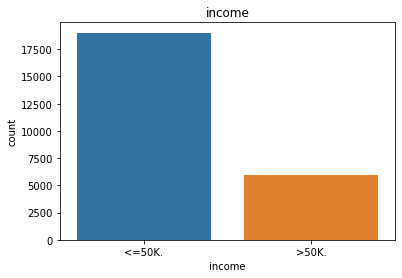

In [8]:
ax = sns.countplot(train_data['income'])
ax.set_title("income")

In [9]:
train_data=train_data.drop(columns=['education'])
train_data['income_above_50K']=train_data['income'].map({'<=50K.':0, '>50K.':1})
train_data=train_data.drop(columns=['income'])

In [10]:
train_data.head()

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_above_50K
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [11]:
#Generate profile report to output.html
profile_report = ProfileReport(train_data)
profile_report.to_file(output_file='data_quality_output.html')

In [11]:
#list of all the numerical perdictors
lst_num = ['age', 'demogweight','education-num','capital-gain','capital-loss','hours-per-week']
# Numirical Value overview
train_data[lst_num].describe()

,age,demogweight,education-num,capital-gain,capital-loss,hours-per-week
count,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000
mean,38.606920,1.897418e+05,10.081440,1088.579040,86.49992,40.407440
std,13.687769,1.052947e+05,2.557035,7486.621197,401.25358,12.299267
min,17.000000,1.228500e+04,1.000000,0.000000,0.00000,1.000000
25%,28.000000,1.179630e+05,9.000000,0.000000,0.00000,40.000000
50%,37.000000,1.783530e+05,10.000000,0.000000,0.00000,40.000000
75%,48.000000,2.368610e+05,12.000000,0.000000,0.00000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.00000,99.000000


In [12]:
#Plot correlation matrix
correlations = train_data[lst_num].corr()
correlations

,age,demogweight,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.075810,0.032765,0.073591,0.056408,0.069045
demogweight,-0.075810,1.000000,-0.043853,0.004366,-0.012152,-0.015179
education-num,0.032765,-0.043853,1.000000,0.120998,0.078483,0.145903
capital-gain,0.073591,0.004366,0.120998,1.000000,-0.031346,0.079760
capital-loss,0.056408,-0.012152,0.078483,-0.031346,1.000000,0.055278
hours-per-week,0.069045,-0.015179,0.145903,0.079760,0.055278,1.000000


In [13]:
def plot(train, column):
    if train[column].dtype != 'int64' and train[column].dtype != 'float64':
        f, axes = plt.subplots(1,1,figsize=(8,3))
        sns.countplot(x=column, hue='income_above_50K', data = train)
        plt.xticks(rotation=90)
        plt.suptitle(column,fontsize=20)
        plt.show()
    else:
        g = sns.FacetGrid(train, row="income_above_50K", margin_titles=True, aspect=4, height=2)
        g.map(plt.hist,column,bins=100)
        plt.show()
    plt.show()



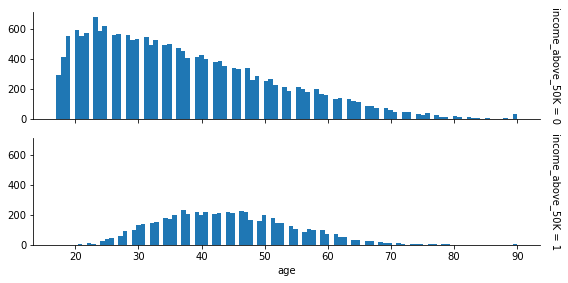

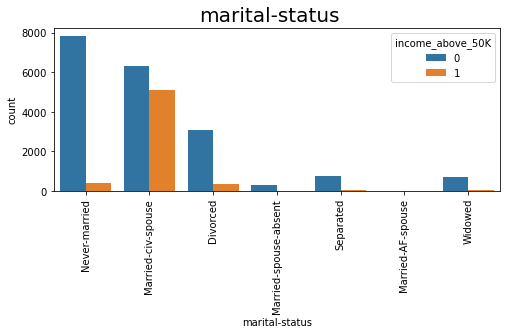

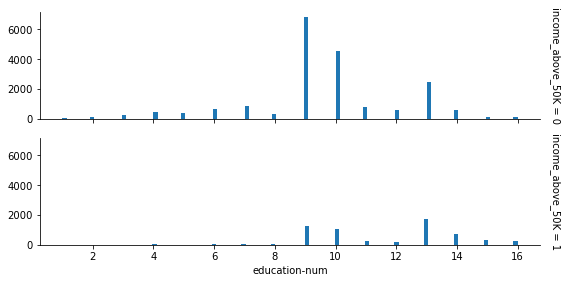

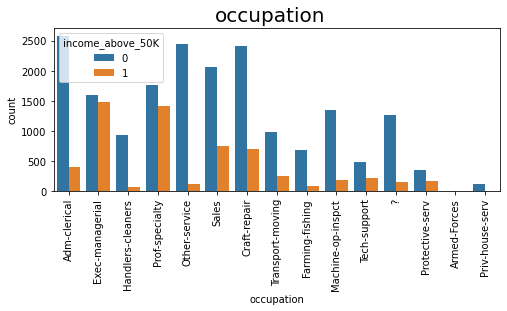

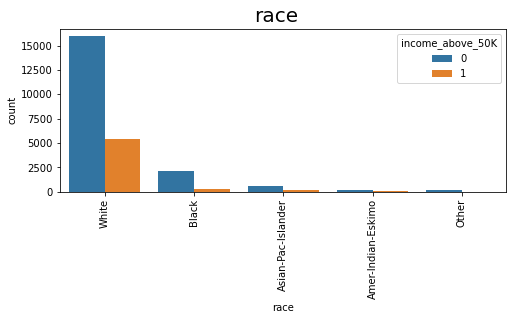

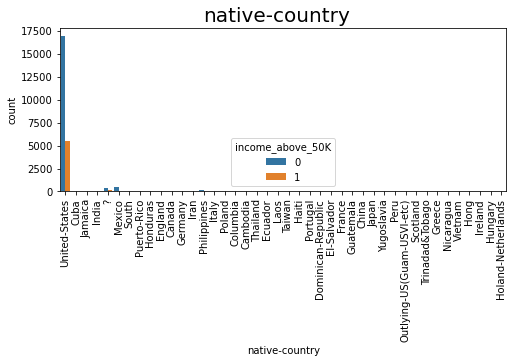

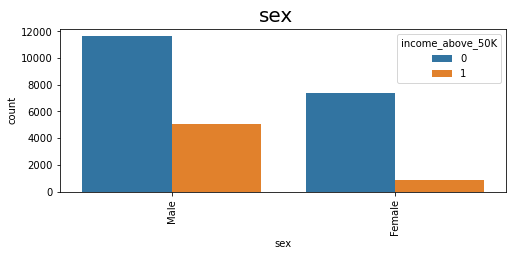

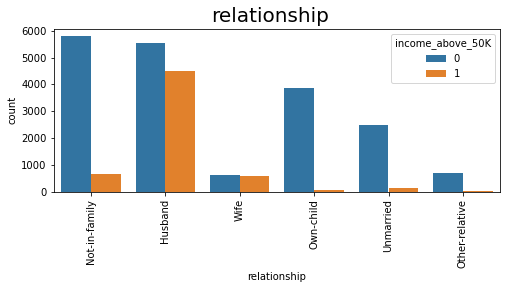

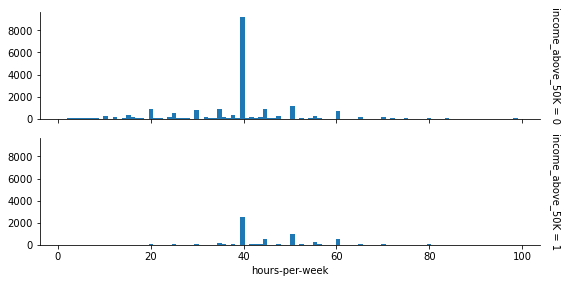

In [15]:
lst = ['age', 'marital-status','education-num','occupation','race','native-country', 'sex','relationship','hours-per-week']
for var in lst:
    plot(train_data, var)

In [14]:
#create a dummy variable for each category in each column
train_data = pd.get_dummies(train_data, columns=['workclass','marital-status','occupation','relationship','race', 'sex','native-country'])

In [18]:
train_data=train_data.drop('native-country_Holand-Netherlands',axis=1)

In [51]:
columns_lst = train_data.columns
len(columns_lst)

92

# Neural Network

In [30]:
scaler = preprocessing.MinMaxScaler()
scaled_dataset = scaler.fit_transform(train_data)
scaled_dataset = pd.DataFrame(scaled_dataset, columns = columns_lst)
scaled_dataset.describe()

,age,demogweight,education-num,capital-gain,capital-loss,hours-per-week,income_above_50K,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,...,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.295985,0.120521,0.605429,0.010886,0.019858,0.402117,0.239360,0.055960,0.030000,0.06496,...,0.001120,0.00384,0.000360,0.002560,0.001680,0.000600,0.000480,0.896840,0.002000,0.000440
std,0.187504,0.071511,0.170469,0.074867,0.092115,0.125503,0.426701,0.229849,0.170591,0.24646,...,0.033448,0.06185,0.018971,0.050533,0.040954,0.024488,0.021904,0.304174,0.044678,0.020972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.071772,0.533333,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.273973,0.112786,0.600000,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.424658,0.152522,0.733333,0.000000,0.000000,0.448980,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
X = scaled_dataset.drop(columns=["income_above_50K"])
y = scaled_dataset["income_above_50K"]

In [32]:
def get_score(X, y, model):
    # define cross validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    # evaluate score
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [33]:
# define a naive model
model = DummyClassifier(strategy='most_frequent')
score = get_score(X, y, model)
print('Mean Accuracy: %.4f (%.4f)' % (np.mean(score), np.std(score)))

Mean Accuracy: 0.7606 (0.0002)


A basic algorithm has an accuracy level of 76%. Therefore any model that has an accuracy level higher than 76% will be a useful model

In [34]:
def create_classifier(neuron1=1, neuron2=1):
    model = Sequential()
    model.add(Dense(neuron1, input_dim=X.shape[1], kernel_initializer='uniform',activation='relu'))
    if neuron2!=0: 
        model.add(Dense(neuron2,kernel_initializer='uniform', activation='relu'))
    else:
        pass
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["accuracy"]) 
    return model

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Best Model Using Keras ANN

In [25]:
### grid search altogether for activation function, loss function, layer nodes,batch size and epochs
model =  KerasClassifier(build_fn=create_classifier)
param_grid = dict( neuron1 = [ 5, 10, 15, 20, 25], neuron2 = [0, 5, 10, 15, 20, 25],
                  epochs = [32,64,96],batch_size=[30,50,70])
grid = GridSearchCV(estimator = model, param_grid = param_grid,n_jobs=-1, cv=3) 

In [26]:
# # ## CAREFUL!! THIS TAKES 2 HOURS
grid_result = grid.fit(X_train, y_train)

Epoch 1/96
400/400 [==============================] - 1s 754us/step - loss: 0.5294 - accuracy: 0.7623
Epoch 2/96
400/400 [==============================] - 0s 1ms/step - loss: 0.3656 - accuracy: 0.8281
Epoch 3/96
400/400 [==============================] - 0s 1ms/step - loss: 0.3468 - accuracy: 0.8358
Epoch 4/96
400/400 [==============================] - 0s 828us/step - loss: 0.3266 - accuracy: 0.8478
Epoch 5/96
400/400 [==============================] - 0s 769us/step - loss: 0.3296 - accuracy: 0.8456
Epoch 6/96
400/400 [==============================] - 0s 749us/step - loss: 0.3216 - accuracy: 0.8536
Epoch 7/96
400/400 [==============================] - 0s 774us/step - loss: 0.3214 - accuracy: 0.8464
Epoch 8/96
400/400 [==============================] - 0s 772us/step - loss: 0.3197 - accuracy: 0.8505
Epoch 9/96
400/400 [==============================] - 0s 762us/step - loss: 0.3121 - accuracy: 0.8531
Epoch 10/96
400/400 [==============================] - 0s 769us/step - loss: 0.3141 - 

In [27]:
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8537000020345052
{'batch_size': 50, 'epochs': 96, 'neuron1': 20, 'neuron2': 10}


In [27]:
batch=50
epo=96
n1=20
n2=10

In [36]:
def create_best_classifier2(neurons1=n1,neurons2=n2):
    #create model:
    model = Sequential()
    model.add(Dense(neurons1, input_dim=X.shape[1], kernel_initializer='uniform', activation='relu'))
    if neurons2!=0: 
        model.add(Dense(neurons2, kernel_initializer='uniform', activation='relu'))
    else:
        pass
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
bestmodel = KerasClassifier(build_fn=create_best_classifier2)
bestmodel.fit(X_train, y_train, validation_data = (X_test,y_test), batch_size = batch, epochs = epo)

Epoch 1/96
400/400 [==============================] - 1s 1ms/step - loss: 0.5570 - accuracy: 0.7634 - val_loss: 0.3732 - val_accuracy: 0.8288
Epoch 2/96
400/400 [==============================] - 0s 932us/step - loss: 0.3737 - accuracy: 0.8248 - val_loss: 0.3517 - val_accuracy: 0.8424
Epoch 3/96
400/400 [==============================] - 0s 920us/step - loss: 0.3601 - accuracy: 0.8286 - val_loss: 0.3397 - val_accuracy: 0.8448
Epoch 4/96
400/400 [==============================] - 0s 987us/step - loss: 0.3485 - accuracy: 0.8387 - val_loss: 0.3361 - val_accuracy: 0.8434
Epoch 5/96
400/400 [==============================] - 0s 897us/step - loss: 0.3390 - accuracy: 0.8419 - val_loss: 0.3249 - val_accuracy: 0.8502
Epoch 6/96
400/400 [==============================] - 0s 925us/step - loss: 0.3262 - accuracy: 0.8469 - val_loss: 0.3243 - val_accuracy: 0.8514
Epoch 7/96
400/400 [==============================] - 0s 1ms/step - loss: 0.3256 - accuracy: 0.8493 - val_loss: 0.3190 - val_accuracy: 0.8

In [38]:
y_pred = bestmodel.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
classificationSummary(y_test, y_pred)

Confusion Matrix (Accuracy 0.8564)

       Prediction
Actual    0    1
     0 3499  304
     1  414  783


C:\Users\hmyma\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
perm = PermutationImportance(bestmodel,random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

625/625 [==============================] - 1s 856us/step - loss: 0.2793 - accuracy: 0.8710


Weight,Feature
0.0389 ± 0.0019,capital-gain
0.0273 ± 0.0018,education-num
0.0266 ± 0.0022,marital-status_Never-married
0.0207 ± 0.0014,age
0.0121 ± 0.0017,marital-status_Divorced
0.0110 ± 0.0014,sex_Female
0.0079 ± 0.0012,occupation_Craft-repair
0.0073 ± 0.0006,workclass_Self-emp-not-inc
0.0071 ± 0.0015,hours-per-week
0.0070 ± 0.0010,capital-loss


C:\Users\hmyma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hmyma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='education-num', ylabel='Density'>

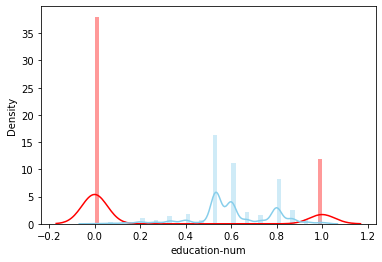

In [39]:
sns.distplot( scaled_dataset["income_above_50K"] , color="red")
sns.distplot( scaled_dataset['education-num'] , color="skyblue")

C:\Users\hmyma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hmyma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='demogweight', ylabel='Density'>

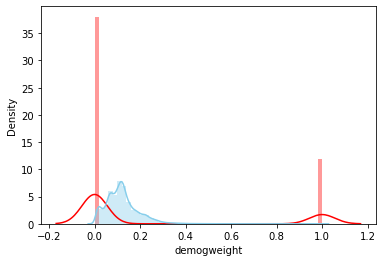

In [45]:
sns.distplot( scaled_dataset["income_above_50K"] , color="red")
sns.distplot( scaled_dataset['demogweight'] , color="skyblue")

C:\Users\hmyma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hmyma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hours-per-week', ylabel='Density'>

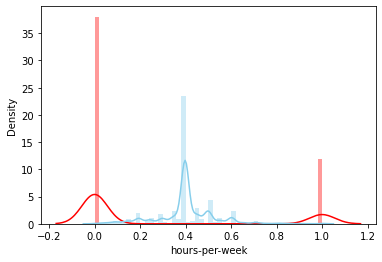

In [47]:
sns.distplot( scaled_dataset["income_above_50K"] , color="red")
sns.distplot( scaled_dataset['hours-per-week'] , color="skyblue")

# Compare Models

In [48]:
# list of model to evaluate
models, names = list(), list()
# Keras
models.append(KerasClassifier(build_fn=create_classifier, epochs=30, batch_size = 20, verbose = 2))
names.append('Keras')
# CART
models.append(DecisionTreeClassifier())
names.append('CART')
# RFC
models.append(RandomForestClassifier(n_estimators=100))
names.append('RFC')
# GBC
models.append(GradientBoostingClassifier(n_estimators=100))
names.append('GBC')

In [49]:
# evaluate each model
for m, n in zip(models, names):
    score = get_score(X, y, m)
    print(n,'Mean Accuracy: %.4f (%.4f)' % (np.mean(score), np.std(score)))

Keras Mean Accuracy: 0.7877 (0.0414)
CART Mean Accuracy: 0.8147 (0.0083)
RFC Mean Accuracy: 0.8572 (0.0057)
GBC Mean Accuracy: 0.8654 (0.0057)


# Model Using Gradient Boosting

In [40]:
learning_rate=[0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = dict(learning_rate=learning_rate)
grid = GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=100), param_grid=param_grid)
grid_result = grid.fit(X_train,y_train)
lr=grid_result.best_params_.get('learning_rate')
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.868050 using {'learning_rate': 0.5}


In [41]:
#create best model:
model2=GradientBoostingClassifier(n_estimators=100,learning_rate=lr)
model2.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5)

In [42]:
y_pred = model2.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
classificationSummary(y_test, y_pred)

Confusion Matrix (Accuracy 0.8728)

       Prediction
Actual    0    1
     0 3552  251
     1  385  812


# Predict on Test Data

In [59]:
test_data= pd.read_csv("USCensusTest.csv")
test_data=test_data.drop(columns=['education'])
#create a dummy variable for each category in each column
test_data = pd.get_dummies(test_data, columns=
                           ['workclass','marital-status','occupation','relationship',
                            'race', 'sex','native-country'])

scaler = preprocessing.MinMaxScaler()
scaled_dataset_test = scaler.fit_transform(test_data)

In [62]:
predictions = bestmodel.predict(scaled_dataset_test)
rounded = [round(p[0]) for p in predictions]
test_output=open('FinalTeam10Predictions.txt','w')
for p in rounded:
    test_output.write(str(p))
    test_output.write('\n')
test_output.close()

C:\Users\hmyma\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
